In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/cleaned_rossmann.csv", parse_dates=["Date"])
df = df.sort_values(["Store", "Date"])
df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,sales_rolling_7
0,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,5530.0
1,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,4928.5
2,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,4781.0
3,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,4835.0
4,1,1,2013-01-07,7176,785,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,5303.2


In [2]:
#Creating price proxy
df["price_proxy"] = 1 - df["Promo"] * 0.15

In [3]:
#Log transform
df["log_sales"] = np.log(df["Sales"])
df["log_price"] = np.log(df["price_proxy"])

In [4]:
#Lagged demand
df["lag_1"] = df.groupby("Store")["log_sales"].shift(1)
df["lag_7"] = df.groupby("Store")["log_sales"].shift(7)

In [5]:
#Rolling volatility
df["volatility_7"] = df.groupby("Store")["log_sales"].transform(lambda x: x.rolling(7).std())


In [6]:
#Trend strength
df["trend_7"] = df.groupby("Store")["log_sales"].transform(lambda x: x.rolling(7).mean())

In [7]:
#Drop na from shifts
df = df.dropna().copy()


In [8]:
#Regime labelling
df["regime"] = "stable"

df.loc[df["volatility_7"] > df["volatility_7"].quantile(0.75), "regime"] = "volatile"
df.loc[df["trend_7"] > df["trend_7"].quantile(0.75), "regime"] = "growth"
df.loc[df["trend_7"] < df["trend_7"].quantile(0.25), "regime"] = "decline"

df["regime"].value_counts()


regime
stable      159803
decline     104262
growth      104262
volatile     48722
Name: count, dtype: int64

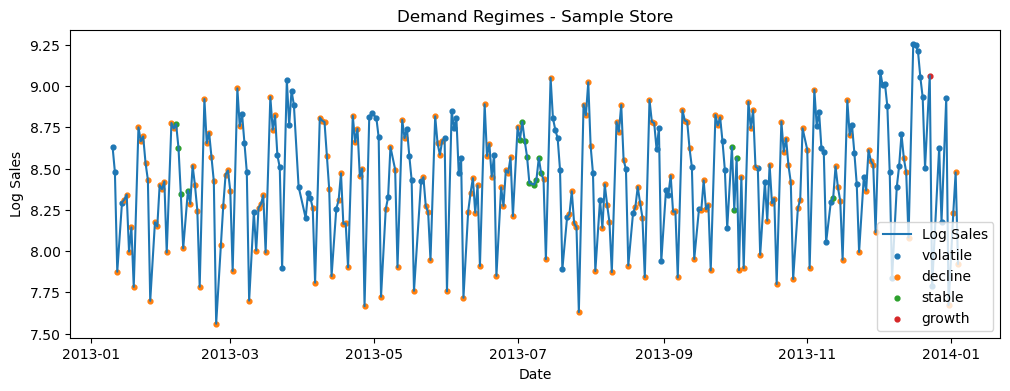

In [15]:
#Visualize regimes
sample = df[df["Store"] == df["Store"].iloc[0]]
sample = sample.iloc[:300]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(sample["Date"], sample["log_sales"], label="Log Sales")

for r in sample["regime"].unique():
    sub = sample[sample["regime"] == r]
    plt.scatter(sub["Date"], sub["log_sales"], label=r, s=12)

plt.legend()
plt.title("Demand Regimes - Sample Store")
plt.xlabel("Date")
plt.ylabel("Log Sales")
plt.show()



In [16]:
df["regime"].value_counts()



regime
stable      159803
decline     104262
growth      104262
volatile     48722
Name: count, dtype: int64